In [125]:
from crm import Network

In [126]:
import re
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from sklearn.model_selection import train_test_split
random.seed(20)
torch.manual_seed(20)

In [127]:
import dill
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        dill.dump(obj, outp, dill.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as inp:
        return dill.load(inp)

# Data

In [128]:
inputs = load_object("data/inputs.dill")
outputs = load_object("data/outputs.dill")

In [129]:
torch_dataset_inputs = torch.rand(700, 23)
for i in range(700):
    torch_dataset_inputs[i] = torch.tensor(list(inputs[i].values())[:23])

In [130]:
torch_dataset_outputs = torch.stack([outputs[i] for i in range(700)], dim=0)

In [131]:
adj_list = load_object("data/adj_list.dill")

# Training

In [132]:
n = Network(num_neurons, adj_list)

In [133]:
n.set_neuron_activation(1282, lambda x : x, lambda x : 1)

In [134]:
n.set_neuron_activation(1283, lambda x : x, lambda x : 1)

In [118]:
n.weights = load_object("weights_train_test_split__seed_20.dill")

In [135]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=1/7, random_state=20, shuffle=True)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

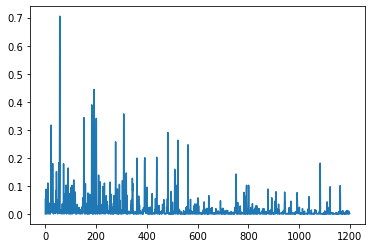

In [86]:
optimizer = torch.optim.Adam(n.parameters(), lr=0.001)
losses = []
num_epochs = 2
for e in trange(num_epochs):
    for i in trange(len(X_train)):
        f_mapper = X_train[i]
        out = n.forward(f_mapper).reshape(1, -1)
        loss = F.cross_entropy(out, y_train[i].reshape(1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        n.reset()
# print(n.weights)
plt.plot(losses)
plt.show()

In [120]:
train_correct = 0
for i in trange(len(X_train)):
    f_mapper = X_train[i]
    out = n.forward(f_mapper).reshape(1, -1)
    train_correct += 1 if torch.argmax(out)==y_train[i] else 0
    n.reset()
print("Train Accuracy: ", train_correct/len(X_train)*100)

  0%|          | 0/600 [00:00<?, ?it/s]

Train Accuracy:  100.0


In [121]:
test_correct = 0
for i in trange(len(X_test)):
    f_mapper = X_test[i]
    out = n.forward(f_mapper).reshape(1, -1)
    test_correct += 1 if torch.argmax(out)==y_test[i] else 0
    n.reset()
print("Test Accuracy: ", test_correct/len(X_test)*100)

  0%|          | 0/100 [00:00<?, ?it/s]

Test Accuracy:  100.0


In [101]:
n.reset()
n.forward(dataset[450][0])
n.lrp(torch.tensor(100.), 1283)

In [102]:
max_layer = max([nn.layer for nn in n.neurons])
max_layer

3

In [103]:
layers = {}
for nn in n.neurons:
    if nn.layer in layers:
        layers[nn.layer].append(nn.n_id)
    else:
        layers[nn.layer]=[nn.n_id]

In [107]:
sum([n.neurons[n_id].relevance for n_id in layers[2]])

tensor([77.5520], grad_fn=<AddBackward0>)

In [110]:
len(layers[2])

931

In [105]:
max_rel = -1
idx = -1
rels = []
for n_id in range(1284):
    if True:#1283 in n.neurons[n_id].successor_neurons or 1282 in n.neurons[n_id].successor_neurons:
        try:
            rels.append((n.neurons[n_id].relevance.item(), n_id, n.neurons[n_id].layer))
        except:
            pass
rels.sort(reverse=True)
rels[:15]

[(100.0, 1283, 3),
 (38.31831359863281, 22, 0),
 (20.276439666748047, 20, 0),
 (16.41777801513672, 23, 1),
 (15.62519645690918, 25, 1),
 (14.337860107421875, 21, 0),
 (8.297679901123047, 19, 0),
 (7.704973220825195, 97, 1),
 (6.702298641204834, 14, 0),
 (5.8988213539123535, 34, 1),
 (5.820578575134277, 15, 0),
 (5.541997909545898, 12, 0),
 (2.9191713333129883, 712, 2),
 (2.3127784729003906, 29, 1),
 (2.2477352619171143, 756, 2)]

In [114]:
# TrainSet: Top1%         Top3%
# TestSet: Top1%       Top3%
# Want to see: hasCar(X,Y), short(Y), closed(Y)

In [112]:
1/931*77.552

0.08329967776584318

In [113]:
2.24

2.24

In [106]:
n.neurons[711].relevance

tensor([0.6337], grad_fn=<AddBackward0>)

In [96]:
dataset[240][0][24]

1

In [77]:
demo = Network(6, [[4], [4], [5], [5], [], []])
demo.weights = {
        (0, 4): torch.tensor(6.0, requires_grad=True),
        (1, 4): torch.tensor(5.0, requires_grad=True),
        (2, 5): torch.tensor(4.0, requires_grad=True),
        (3, 5): torch.tensor(6.0, requires_grad=True),
}
demo.forward({0: 1, 1: -1, 2: 2, 3: -1, 4: 1, 5: 1})
print([demo.neurons[i].value for i in range(len(demo.neurons))])
demo.lrp(torch.tensor(10.0), 5)
print([demo.neurons[i].relevance for i in range(len(demo.neurons))])

[tensor(1), tensor(-1), tensor(2), tensor(-1), tensor(1., grad_fn=<MulBackward0>), tensor(2., grad_fn=<MulBackward0>)]
[tensor(0., grad_fn=<AddBackward0>), tensor(0., grad_fn=<AddBackward0>), tensor(40., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), 0, tensor(10.)]


In [78]:
d_layers = {}
for nn in demo.neurons:
    if nn.layer in d_layers:
        d_layers[nn.layer].append(nn.n_id)
    else:
        d_layers[nn.layer]=[nn.n_id]

In [79]:
d_layers

{0: [0, 1, 2, 3], 1: [4, 5]}

In [81]:
sum([demo.neurons[n_id].relevance for n_id in d_layers[1]])

tensor(10.)

In [85]:
max_rel = -1
idx = -1
rels = []
for n_id in range(1284):
    if True:#1283 in n.neurons[n_id].successor_neurons or 1282 in n.neurons[n_id].successor_neurons:
        try:
            rels.append((n.neurons[n_id].relevance.item(), n_id, n.neurons[n_id].layer))
        except:
            pass
rels.sort(reverse=True)
rels[:15]

[(100.0, 1283, 3),
 (50.09611511230469, 22, 0),
 (28.143735885620117, 23, 1),
 (25.122875213623047, 21, 0),
 (11.22695541381836, 3, 0),
 (10.006945610046387, 18, 0),
 (7.728886127471924, 298, 1),
 (4.784719467163086, 25, 1),
 (3.5847561359405518, 712, 2),
 (3.547109842300415, 19, 0),
 (3.1040234565734863, 713, 2),
 (2.742990493774414, 757, 2),
 (2.4108364582061768, 632, 2),
 (2.3875539302825928, 859, 2),
 (2.3309028148651123, 29, 1)]

In [184]:
optimizer = torch.optim.Adam(n.parameters(), lr=0.001)
losses = []
correct = 0
for i in trange(len(dataset)):
    f_mapper = dataset[i][0]
    f_mapper[1282]=1
    f_mapper[1283]=1
    out = n.forward(f_mapper).reshape(1, -1)
    correct += 1 if torch.argmax(out)==dataset[i][1] else 0
    n.reset()
print(correct/700*100)
# print(n.weights)
print(losses)
# plt.plot(losses)
# plt.show()

  0%|          | 0/700 [00:00<?, ?it/s]

100.0
[]


In [59]:
save_object(n, "network_100.pkl")

In [60]:
loaded_network_n = load_object("network_100.pkl")

In [70]:
loaded_network_n.reset()

In [48]:
optimizer = torch.optim.Adam(n.parameters(), lr=0.001)
losses = []
correct = 0
for i in trange(len(dataset)):
    f_mapper = dataset[i][0]
    f_mapper[1282]=1
    f_mapper[1283]=1
    out = loaded_network_n.forward(f_mapper).reshape(1, -1)
    correct += 1 if torch.argmax(out)==dataset[i][1] else 0
    loaded_network_n.reset()
print(correct/700*100)
# print(n.weights)
print(losses)
# plt.plot(losses)
# plt.show()

  0%|          | 0/700 [00:00<?, ?it/s]

NameError: name 'loaded_network_n' is not defined

In [63]:
len(n.weights)

4992

In [68]:
save_object(n.weights, "weights_100_trained_on_600_samples.pkl")

In [69]:
w = load_object("weights_100_trained_on_600_samples.pkl")

In [70]:
n.weights = w

In [54]:
# https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function
import torch
for f in f_mapper_global:
    f[1282]=1
    f[1283]=1
    n.reset()
    o = n.forward(f)
    if o[0]!=torch.tensor([0.]):
        print(o)
        break

In [60]:
m = torch.nn.Sequential(torch.nn.Linear(10, 100))

In [72]:
list(m.parameters())[1]

Parameter containing:
tensor([ 0.2583, -0.2650, -0.1380,  0.2627, -0.0312,  0.1305, -0.2825,  0.2821,
        -0.1505, -0.1986,  0.1177, -0.0656, -0.2120,  0.2727,  0.2055,  0.2070,
         0.0710,  0.1732,  0.0441,  0.2178,  0.0877,  0.0890, -0.2641,  0.1323,
         0.2862,  0.1050, -0.0550,  0.0561,  0.1339,  0.1444, -0.1224,  0.0247,
        -0.2285, -0.1712,  0.2991,  0.2760,  0.3068, -0.2236,  0.1844,  0.2605,
         0.1401, -0.1417,  0.0496, -0.2446,  0.2426,  0.2560,  0.0176, -0.0214,
         0.0734, -0.2629, -0.1454, -0.0164, -0.2263, -0.1252,  0.2839,  0.1112,
        -0.1526, -0.2420,  0.1288, -0.2328, -0.1631, -0.2980, -0.2495,  0.0282,
         0.2589,  0.1794, -0.2060,  0.0578, -0.1831, -0.0485,  0.1794,  0.1493,
        -0.2882, -0.2283,  0.1230, -0.0346,  0.0167, -0.0178,  0.0618,  0.3064,
         0.2408, -0.1345,  0.1730,  0.0623,  0.2448,  0.2489,  0.2486, -0.2769,
         0.0622, -0.0840, -0.0709,  0.1767, -0.0693,  0.1541,  0.2729,  0.1055,
         0.1617, -

In [78]:
input_neurons = []
for neuron in n.neurons:
    if len(neuron.predeccesor_neurons)==0:
        input_neurons.append(neuron.n_id)

In [92]:
input_neurons

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22]

In [110]:
class MLP(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(nn.Linear(inp_dim, 64), nn.ReLU(), nn.Linear(64, 32),nn.ReLU(), nn.Linear(32, 2))
    def forward(self, x):
        return self.mlp(x)

In [166]:
mlp = MLP(23, 2)

In [167]:
losses = []

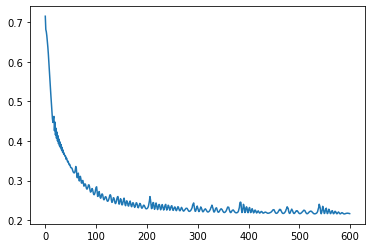

In [168]:
num_epochs = 600
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

for i in range(num_epochs):
    out = mlp(torch_dataset_inputs)
    loss = F.cross_entropy(out, torch_dataset_outputs)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
plt.plot(losses)
plt.show()

In [169]:
losses[-1]

0.21631726622581482

In [170]:
trained_out = mlp(torch_dataset_inputs)

In [178]:
(torch.argmax(trained_out, dim=1) == torch_dataset_outputs).sum()

tensor(613)

In [179]:
613/700

0.8757142857142857

In [181]:
torch.jit.script(mlp).save("torch_model_87_57.pt")

In [191]:
mlp.mlp[0]

Linear(in_features=23, out_features=64, bias=True)

In [198]:
from captum.attr import LayerLRP
lrp = LayerLRP(mlp, mlp.mlp[0])
# Attribution size matches input size: 3x3x32x32
attribution = lrp.attribute(torch_dataset_inputs[0], target=1)

AssertionError: Cannot choose target column with output shape torch.Size([2]).

In [204]:
def get_nth_key(dictionary, n=0):
    if n < 0:
        n += len(dictionary)
    for i, key in enumerate(dictionary.keys()):
        if i == n:
            return key
    raise IndexError("dictionary index out of range") 

In [208]:
a, b = get_nth_key(n.weights, 132)
b

1203

In [52]:
for i in range(len(n.weights)):
    a, b = get_nth_key(n.weights, i)
    if a in input_neurons:
        print((a, b), n.weights[(a, b)])

In [50]:
n.output_neurons

[1282, 1283]

In [109]:
n.neurons[1283].value

tensor([65.8915], grad_fn=<MulBackward0>)

In [106]:
n.reset()

In [107]:
# dataset[2][0]

In [108]:
n.forward(dataset[24][0])

tensor([[60.5862],
        [65.8915]], grad_fn=<StackBackward0>)

In [97]:
dataset[0][1]

tensor(1)

In [88]:
for i in range(700):
    if dataset[i][1]==torch.tensor(0):
        print(i)
        break

2


In [ ]:
n.lrp(torch.tensor(100), 1283)

In [102]:
n.neurons[30].relevance, n.neurons[26].relevance

(tensor([1.3627], grad_fn=<AddBackward0>),
 tensor([1.0818], grad_fn=<AddBackward0>))

In [101]:
val = -1
idx= -1 
for i in range(len(n.neurons)):
    if val < n.neurons[i].relevance and i!=1283 and len(n.neurons[i].predeccesor_neurons)>0:
        val = n.neurons[i].relevance
        idx=i
print(val, idx)

tensor([13.5326], grad_fn=<AddBackward0>) 25


In [81]:
for neuron in n.neurons:
    if len(neuron.predeccesor_neurons)==0:
        print(neuron.n_id, neuron.relevance)

0 tensor([2.5776], grad_fn=<AddBackward0>)
1 tensor([6.5669], grad_fn=<AddBackward0>)
2 tensor([4.8625], grad_fn=<AddBackward0>)
3 tensor([7.3552], grad_fn=<AddBackward0>)
4 tensor([1.6697], grad_fn=<AddBackward0>)
5 tensor([4.3789], grad_fn=<AddBackward0>)
6 tensor([2.8425], grad_fn=<AddBackward0>)
7 tensor([3.3122], grad_fn=<AddBackward0>)
8 tensor([3.0336], grad_fn=<AddBackward0>)
9 tensor([2.3799], grad_fn=<AddBackward0>)
10 tensor([2.4768], grad_fn=<AddBackward0>)
11 tensor([8.8196], grad_fn=<AddBackward0>)
12 tensor([5.6021], grad_fn=<AddBackward0>)
13 tensor([3.6882], grad_fn=<AddBackward0>)
14 tensor([6.9309], grad_fn=<AddBackward0>)
15 tensor([4.5565], grad_fn=<AddBackward0>)
16 tensor([4.7223], grad_fn=<AddBackward0>)
17 tensor([5.4705], grad_fn=<AddBackward0>)
18 tensor([5.1625], grad_fn=<AddBackward0>)
19 tensor([5.7853], grad_fn=<AddBackward0>)
20 tensor([7.8064], grad_fn=<AddBackward0>)
21 tensor([0.], grad_fn=<AddBackward0>)
22 tensor([0.], grad_fn=<AddBackward0>)


In [50]:
n.neurons[23].predeccesor_neurons

[21, 22]

In [105]:
n.reset()
n.forward(dataset[24][0])

tensor([[60.5862],
        [65.8915]], grad_fn=<StackBackward0>)

In [110]:
n.reset()
n.forward(dataset[24][0])
n.lrp(torch.tensor(100.), 1283)
N_ID = [i for i in range(1284)]
REL_VALS = [n.neurons[n_id].relevance for n_id in N_ID]
S = [x for _,x in sorted(zip(REL_VALS,N_ID))]
S.reverse()

In [69]:
def predict(n, x):
    n.reset()
    out = n.forward(x)
    return torch.argmax(out)

In [70]:
predict(n, dataset[24][0])

tensor(0)

In [85]:
def greedy_lrp(n, dataset_id):
    n.reset()
    x = dataset[dataset_id][0]
    n.forward(x)
    
    if dataset[dataset_id][1]:
        n.lrp(torch.tensor(100.), 1283)
        # print("here")
    else:
        n.lrp(torch.tensor(100.), 1282)
        # print("there")
    
    N_ID = [i for i in range(23)]
    REL_VALS = [n.neurons[n_id].relevance for n_id in N_ID]
    S = [x for _,x in sorted(zip(REL_VALS,N_ID))]
    
    R = []
    found = False
    
    if dataset[dataset_id][1]:
        S.append(1283)
        # print("here")
    else:
        S.append(1282)
        # n.lrp(torch.tensor(100.), 1282)
        # print("there")
    
    S.reverse()
    while (len(S)!=0 and found==False):
        R.append(S[0])
        x_dash = {i: 1 if i in R else 0 for i in range(1284)}
        for n_id in range(1284):
            if len(n.neurons[n_id].predeccesor_neurons)==0:
                continue
            if x_dash[n.neurons[n_id].predeccesor_neurons[0]] and x_dash[n.neurons[n_id].predeccesor_neurons[1]]:
                x_dash[n_id]=1
        out_dash = predict(n, x_dash)
        out = predict(n, x)
        # print(out, out_dash)
        if out_dash == out:
            found = True
        else:
            found = False
        S = S[1:]
    
    print(R)
    # x_real = {i: 1 if i in R else 0 for i in range(1285)}
    # print(x_real)
    # n.reset()
#     out = n.forward(x_real)
#     if dataset[dataset_id][1]:
#         n.lrp(torch.tensor(100.), 1283)
#     else:
#         n.lrp(torch.tensor(100.), 1282)
    
    return R

In [86]:
n.neurons[403].predeccesor_neurons

[97, 180]

In [88]:
n.reset()
n.forward(dataset[458][0])

tensor([[55.7140],
        [61.7247]], grad_fn=<StackBackward0>)

In [90]:
n.neurons[1283].value

tensor([61.7247], grad_fn=<MulBackward0>)

In [ ]:
func(f(35),[type=simple,def=(train(_131143):-has_car(_131143,_131149),open_car(_131149))]).

func(f(19),[type=simple,def=(train(_131143):-has_car(_131143,_131149),open_car(_131149))]).
func(f(23),[type=simple,def=(train(_131143):-has_car(_131143,_131146))]).


In [ ]:
func(f(24),[type=simple,def=(train(_131143):-has_car(_131143,_131149),short(_131149))]).

func(f(23),[type=simple,def=(train(_131143):-has_car(_131143,_131146))]).
func(f(22),[type=simple,def=(train(_131143):-has_car(_131143,_131149),short(_131149))]).

In [91]:
n.lrp(torch.tensor(100.), 1283)

In [92]:
for neuron in n.neurons:
    if len(neuron.predeccesor_neurons)==0:
        print(neuron.n_id, neuron.relevance)

0 tensor([0.], grad_fn=<AddBackward0>)
1 tensor([0.], grad_fn=<AddBackward0>)
2 tensor([0.], grad_fn=<AddBackward0>)
3 tensor([0.], grad_fn=<AddBackward0>)
4 tensor([0.], grad_fn=<AddBackward0>)
5 tensor([0.], grad_fn=<AddBackward0>)
6 tensor([0.], grad_fn=<AddBackward0>)
7 tensor([0.], grad_fn=<AddBackward0>)
8 tensor([0.], grad_fn=<AddBackward0>)
9 tensor([0.], grad_fn=<AddBackward0>)
10 tensor([0.], grad_fn=<AddBackward0>)
11 tensor([0.], grad_fn=<AddBackward0>)
12 tensor([0.], grad_fn=<AddBackward0>)
13 tensor([0.], grad_fn=<AddBackward0>)
14 tensor([0.], grad_fn=<AddBackward0>)
15 tensor([6.4179], grad_fn=<AddBackward0>)
16 tensor([0.], grad_fn=<AddBackward0>)
17 tensor([0.], grad_fn=<AddBackward0>)
18 tensor([0.], grad_fn=<AddBackward0>)
19 tensor([11.4728], grad_fn=<AddBackward0>)
20 tensor([23.7107], grad_fn=<AddBackward0>)
21 tensor([18.0010], grad_fn=<AddBackward0>)
22 tensor([40.3976], grad_fn=<AddBackward0>)


In [94]:
temp_data = {i: 0 for i in range(1284)}
for i in range(23):
    temp_data[i]=0
temp_data[22]=1
for n_id in range(1284):
    if len(n.neurons[n_id].predeccesor_neurons)==0:
        continue
    if temp_data[n.neurons[n_id].predeccesor_neurons[0]] or temp_data[n.neurons[n_id].predeccesor_neurons[1]]:
        temp_data[n_id]=1
n.reset()
n.forward(temp_data)

tensor([[169.3681],
        [176.5970]], grad_fn=<StackBackward0>)

In [87]:
greedy_lrp(n, 458)

[1283, 22, 20]


[1283, 22, 20]

In [84]:
dataset[458][1]

tensor(1)

In [74]:
n.output_neurons

[1282, 1283]

In [172]:
n.reset()
out = n.forward({i: 0 for i in range(1285)})

In [173]:
torch.argmax(out)

tensor(0)

In [153]:
for neuron in n.neurons:
    if len(neuron.predeccesor_neurons)==0:
        print(neuron.n_id, neuron.relevance)

0 tensor([0.], grad_fn=<AddBackward0>)
1 tensor([0.], grad_fn=<AddBackward0>)
2 tensor([0.], grad_fn=<AddBackward0>)
3 tensor([0.], grad_fn=<AddBackward0>)
4 tensor([0.], grad_fn=<AddBackward0>)
5 tensor([0.], grad_fn=<AddBackward0>)
6 tensor([0.], grad_fn=<AddBackward0>)
7 tensor([0.], grad_fn=<AddBackward0>)
8 tensor([0.], grad_fn=<AddBackward0>)
9 tensor([0.], grad_fn=<AddBackward0>)
10 tensor([0.], grad_fn=<AddBackward0>)
11 tensor([0.], grad_fn=<AddBackward0>)
12 tensor([0.], grad_fn=<AddBackward0>)
13 tensor([0.], grad_fn=<AddBackward0>)
14 tensor([0.], grad_fn=<AddBackward0>)
15 tensor([0.], grad_fn=<AddBackward0>)
16 tensor([0.], grad_fn=<AddBackward0>)
17 tensor([0.], grad_fn=<AddBackward0>)
18 tensor([0.], grad_fn=<AddBackward0>)
19 tensor([0.], grad_fn=<AddBackward0>)
20 tensor([0.], grad_fn=<AddBackward0>)
21 tensor([0.], grad_fn=<AddBackward0>)
22 tensor([0.], grad_fn=<AddBackward0>)


In [97]:
if dataset[42][1]:
    print(1)

1


In [98]:
n.reset()
n.forward(dataset[42][0])

tensor([[118.6430],
        [124.5332]], grad_fn=<StackBackward0>)

In [99]:
n.lrp(torch.tensor(100.), 1283)

In [105]:
max_rel = -1
idx = -1
for n_id in range(1284):
    if 1283 in n.neurons[n_id].successor_neurons or 1282 in n.neurons[n_id].successor_neurons:
        if n.neurons[n_id].relevance > max_rel:
            max_rel=n.neurons[n_id].relevance
            idx=n_id
print(max_rel, idx)

tensor([2.2477], grad_fn=<AddBackward0>) 712
